<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Look-at-the-SKy-Model-Directly" data-toc-modified-id="Look-at-the-SKy-Model-Directly-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Look at the SKy Model Directly</a></span></li><li><span><a href="#Power-Spectra" data-toc-modified-id="Power-Spectra-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Power Spectra</a></span></li><li><span><a href="#Monopole-Subtracted-Visibilities" data-toc-modified-id="Monopole-Subtracted-Visibilities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Monopole-Subtracted Visibilities</a></span></li></ul></div>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
from pyradiosky import SkyModel
from pyuvdata.uvdata import FastUVH5Meta
from scipy.optimize import curve_fit
from pathlib import Path

import hera_pspec as hp
from scipy.signal.windows import blackmanharris

In [2]:
from os import environ

In [3]:
sys.path.append("..")

In [4]:
environ['VALIDATION_SYSTEM_NAME'] = 'NRAO'

In [5]:
from core.utils import FREQS_DICT

In [6]:
FREQS = FREQS_DICT['H4C']

In [18]:
def getdata(files):
    meta = FastUVH5Meta(files[0])
    blidx = [meta.antpairs.index(bl) for bl in bls]
    
    data = np.zeros((len(files), meta.Ntimes, len(blidx), 4), dtype=complex)
    freqs = np.zeros(len(files))
    for i, fl in enumerate(files):
        with h5py.File(fl, 'r') as fll:
            freqs[i] = fll['Header']['freq_array'][0]
            _d = fll['Data']['visdata'][()]
            _d.shape = (meta.Ntimes, meta.Nbls, 4)
            data[i] = _d[:, blidx]
    return freqs, data

def getdatabig(files):
    meta = FastUVH5Meta(files[0])
    blidx = np.array([meta.antpairs.index(bl) for bl in bls])
    
    data = np.zeros((len(files), meta.Ntimes//8, len(blidx), 4), dtype=complex)
    freqs = np.zeros(len(files))
    idx = np.concatenate([blidx+(i*meta.Nbls) for i in range(meta.Ntimes//8)])
    
    for i, fl in enumerate(files):
        with h5py.File(fl, 'r') as fll:
            freqs[i] = fll['Header']['freq_array'][0]
            _d = fll['Data']['visdata'][idx]
            _d.shape = (meta.Ntimes//8, len(blidx), 4)
            data[i] = _d
    return freqs, data
    

In [8]:
newsim = sorted(Path("/lustre/aoc/projects/hera/Validation/H4C/IDR2/raw_data/eor-grf-256-subset").glob("*_chunk000*"))[:150]

In [10]:
bettermono_files = sorted(Path("../outputs/eor-grf-128/nt17280-024chunks-MINIMAL").glob("*"))[:150]

In [11]:
bettermono256_files = sorted(Path("../outputs/eor-grf-256/nt17280-024chunks-MINIMAL").glob("*"))[:150]

In [9]:
orig_files = sorted(Path("../outputs/eor/nt17280-024chunks-MINIMAL").glob("*"))[:150]

In [24]:
nside256_files = sorted(Path("../outputs/eor256/nt17280-144chunks-MINIMAL").glob("*"))[:150]

In [25]:
rot_files = sorted(Path("../outputs/eor-rotated/nt17280-048chunks-MINIMAL/").glob("*"))

In [26]:
mono_only_files = sorted(Path("../outputs/uniform_eor_nside128/nt17280-024chunks-MINIMAL").glob("*"))

In [14]:
meta_full = FastUVH5Meta(newsim[0])

In [11]:
meta = FastUVH5Meta(orig_files[0])

In [12]:
bls = [(1,0), (2,0), (4,0), (11, 0), (23, 0), (52, 0)]

In [19]:
freqs, newsimdata = getdatabig(newsim)

In [23]:
freqs, bettermonodata = getdata(bettermono_files)

In [17]:
freqs, bettermonodata256 = getdata(bettermono256_files)

In [24]:
freqs, origdata = getdata(orig_files)

In [43]:
freqs, full256data = getdata(full256)

In [44]:
freqs, fullrotdata = getdata(fullrot)

## Look at Freq-Time Waterfalls

In [20]:
def make_plot(data, cmp='real', pol='xx'):
    fig, ax = plt.subplots(3, 4, sharex=True, constrained_layout=True, figsize=(12, 8), sharey=True)

    def make_half(cmp, ax):
        if pol !='pI':
            d = getattr(data, cmp)[:, :, :, meta.pols.index(pol)].T
        else:
            d = (data[:, :, :, meta.pols.index("xx")] + data[:, :, :, meta.pols.index('yy')])/2
            d = getattr(d, cmp).T

        mn = d.min()
        mx = d.max()

        ext = (freqs[0]/1e6, freqs[-1]/1e6, 2, 0)
        kw = {'extent': ext, 'aspect': 'auto', 'clim': (mn, mx)}

        img = ax[0, 0].imshow(d[0], **kw)
        ax[0, 0].set_title(f"1-unit EW, {cmp}")
        ax[0, 1].imshow(d[3], **kw)
        ax[0, 1].set_title(f"1-unit NS, {cmp}")

        ax[1, 0].imshow(d[1], **kw)
        ax[1, 0].set_title(f"2-unit EW, {cmp}")
        ax[1, 1].imshow(d[4], **kw)
        ax[1, 1].set_title(f"2-unit NS, {cmp}")

        ax[2, 0].imshow(d[2], **kw)
        ax[2, 0].set_title(f"4-unit EW, {cmp}")
        ax[2, 1].imshow(d[5], **kw)
        ax[2, 1].set_title(f"4-unit NS, {cmp}")
        return img
    
    img1 = make_half("real", ax[:, :2])
    img2 = make_half("imag", ax[:, 2:])
    
    fig.suptitle(f"pol={pol}")

    fig.colorbar(img1, ax=ax[:, :2])
    fig.colorbar(img2, ax=ax[:, 2:])

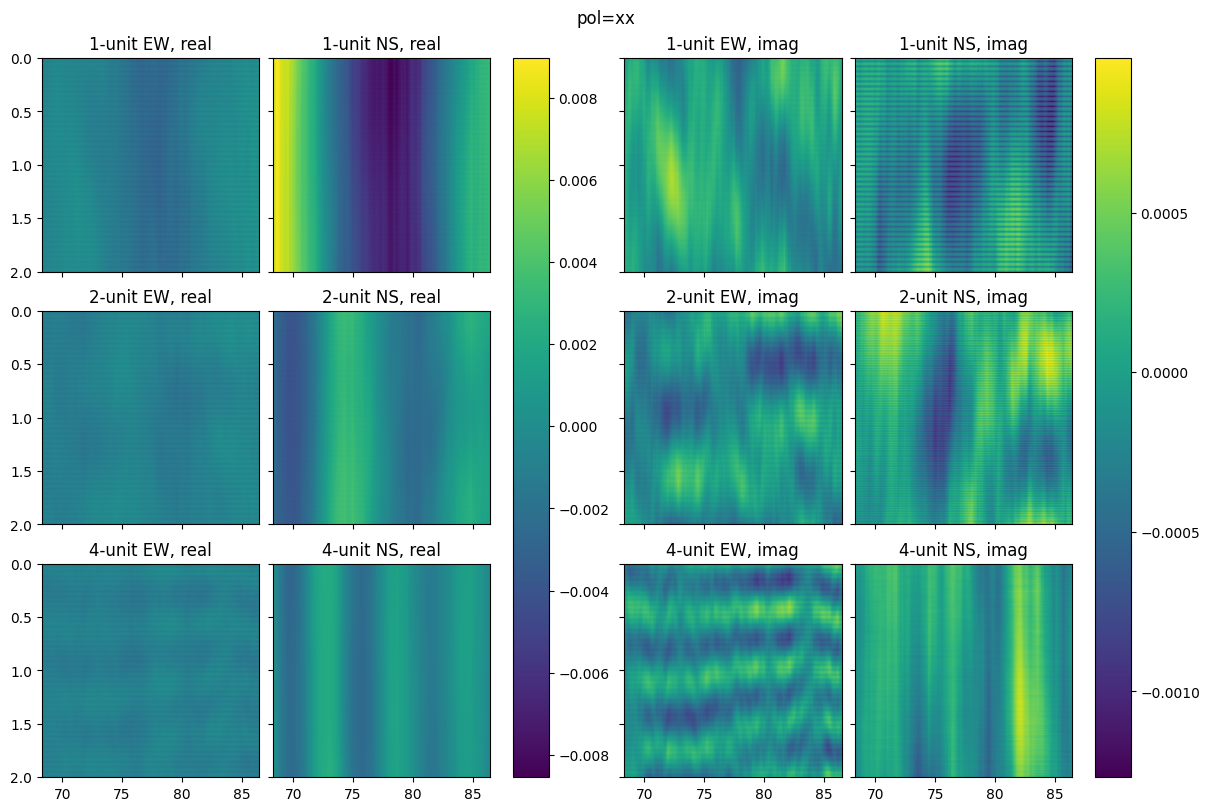

In [25]:
make_plot(origdata, pol='xx')

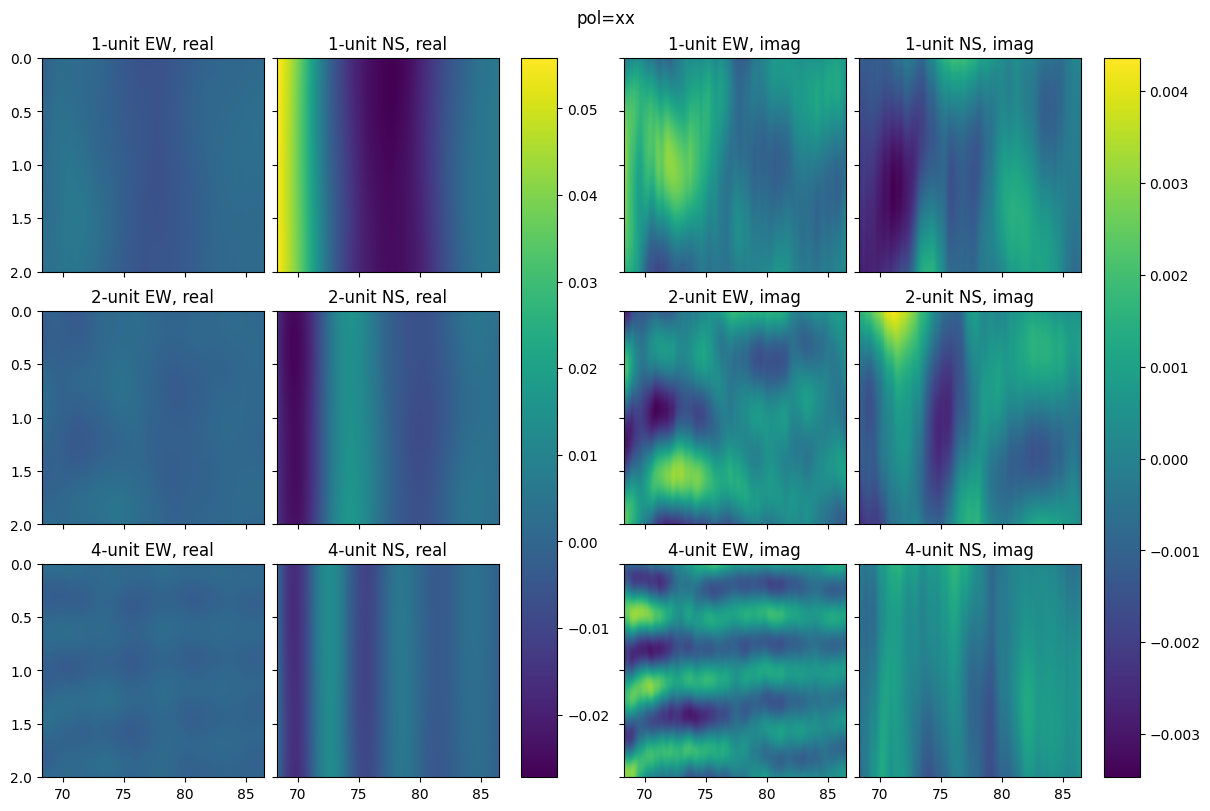

In [21]:
make_plot(newsimdata, pol='xx')

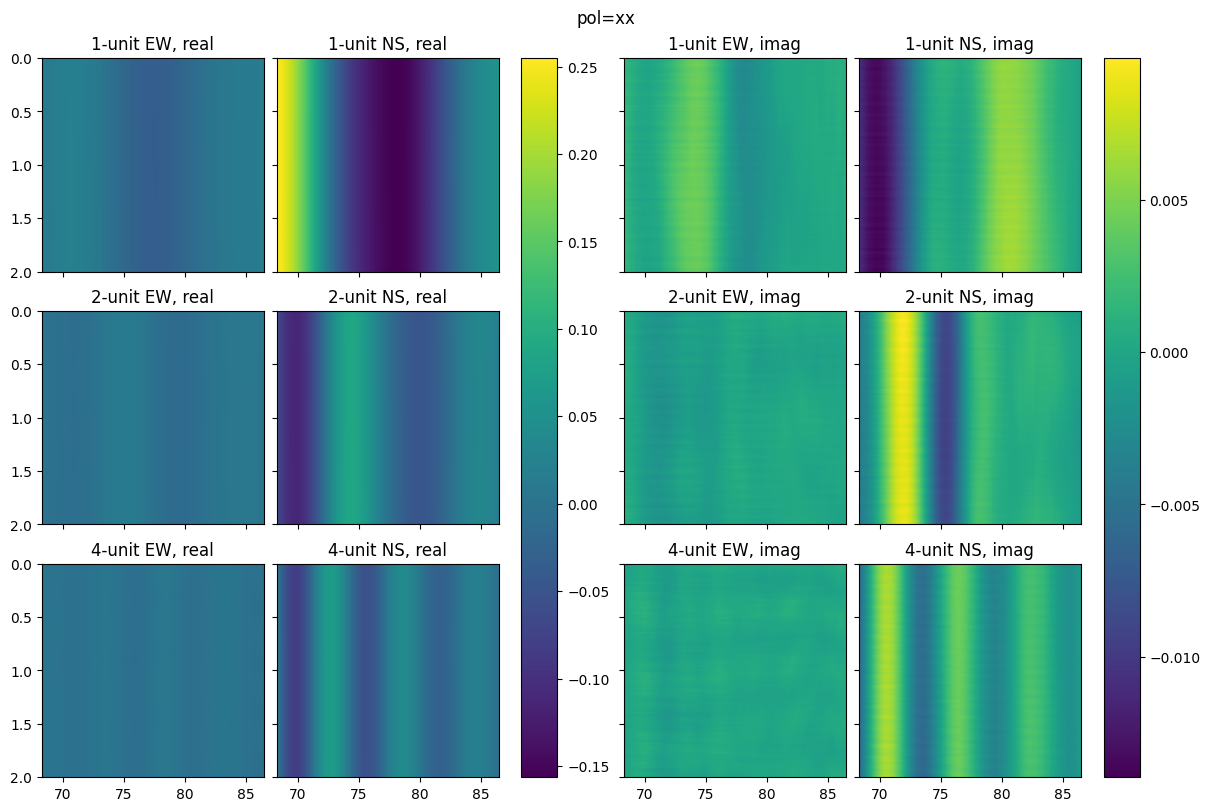

In [26]:
make_plot(bettermonodata, pol='xx')

## Power Spectra

In [38]:
from redshifted_gaussian_fields import generator

In [39]:
covariance_data_path = '/lustre/aoc/projects/hera/zmartino/hera_validation/H4C_IDR2_signal_sim/covariance.h5'

gcfg = generator.restore_from_file(covariance_data_path)

In [27]:
# This is the cosmological parameter set in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hp_cosmo = hp.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hp_cosmo

cosmo = astropyPlanck15_for_hera_pspec()

In [28]:
def get_power(data, pol='xx'):
    if pol=='pI':
        dd = (data.T[0] + data.T[-1])/2
    else:
        dd = data.T[meta.pols.index(pol)]
        
    power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2
    fac = cosmo.tau_to_kpara(z=6.7)
    return np.fft.fftshift(np.mean(power, axis=1), axes=1), np.fft.fftshift(np.fft.fftfreq(data.shape[0], d=FREQS[1]-FREQS[0]) * fac)
    

In [29]:
def get_z_mean(spw):
    return cosmo.f2z(freqs)

In [30]:
def tapered_power_spectrum(k, spw):
    z = get_z_mean(spw)
        
    Pk = gcfg.Pspec(cosmo.h * k)
    
    nu_e = 1420405751.7667 # Hz
    nu_z = nu_e/(1. + z)
    
    # redshift dimming factor
    Pk *= (nu_e/nu_z)**-2
    
    # little-h "units"
    Pk *= cosmo.h**3
    
    # K^2 to mK^2
    Pk *= 1e6
    
    spw_freqs = freqs
    z = cosmo.f2z(np.mean(spw_freqs))
    alpha = cosmo.dRpara_df(z)
    delta_nu = np.median(np.diff(spw_freqs))
    
    x = 0.5 * k * alpha * delta_nu
    taper = np.sinc(x/np.pi)**2
    
    Pk *= taper
    
    return Pk

In [31]:
def get_ks(spw):
    spw_freqs = FREQS[spw[0]:spw[1]]
    z_s = cosmo.f2z(spw_freqs)
    dr = np.diff(np.array([cosmo.DC(z, little_h=True) for z in z_s]))
    
    return np.pi * np.mean(1/np.abs(dr)), cosmo.f2z(np.mean(spw_freqs))

In [32]:
def expected_power_spectrum(k, spw, nterms=20):
    ks, z = get_ks(spw)
    
    Pk = tapered_power_spectrum(k, spw)
    
    for n in range(1,nterms):
        Pk += tapered_power_spectrum(k + 2*n*ks, spw) + tapered_power_spectrum(k - 2*n*ks, spw)
    
    return Pk

In [33]:
orig_power_xx, kfft = get_power(origdata, 'xx')
orig_power_yy, kfft = get_power(origdata, 'yy')
orig_power_pi, kfft = get_power(origdata, 'pI')


In [34]:
bettermono_power_xx, kfft = get_power(bettermonodata, 'xx')
bettermono_power_yy, kfft = get_power(bettermonodata, 'yy')
bettermono_power_pi, kfft = get_power(bettermonodata, 'pI')


In [35]:
newsim_power_xx, kfft = get_power(newsimdata, 'xx')
newsim_power_yy, kfft = get_power(newsimdata, 'yy')
newsim_power_pi, kfft = get_power(newsimdata, 'pI')


In [29]:
bettermono256_power_xx, kfft = get_power(bettermonodata256, 'xx')
bettermono256_power_yy, kfft = get_power(bettermonodata256, 'yy')
bettermono256_power_pi, kfft = get_power(bettermonodata256, 'pI')


In [40]:
expected_pk = expected_power_spectrum(kfft, (175, 325))

/tmp/ipykernel_30363/1631822844.py:12: RuntimeWarning: divide by zero encountered in power
  expected_pk = 2e-7 * kfft**-2.7
/tmp/ipykernel_30363/1631822844.py:12: RuntimeWarning: invalid value encountered in power
  expected_pk = 2e-7 * kfft**-2.7


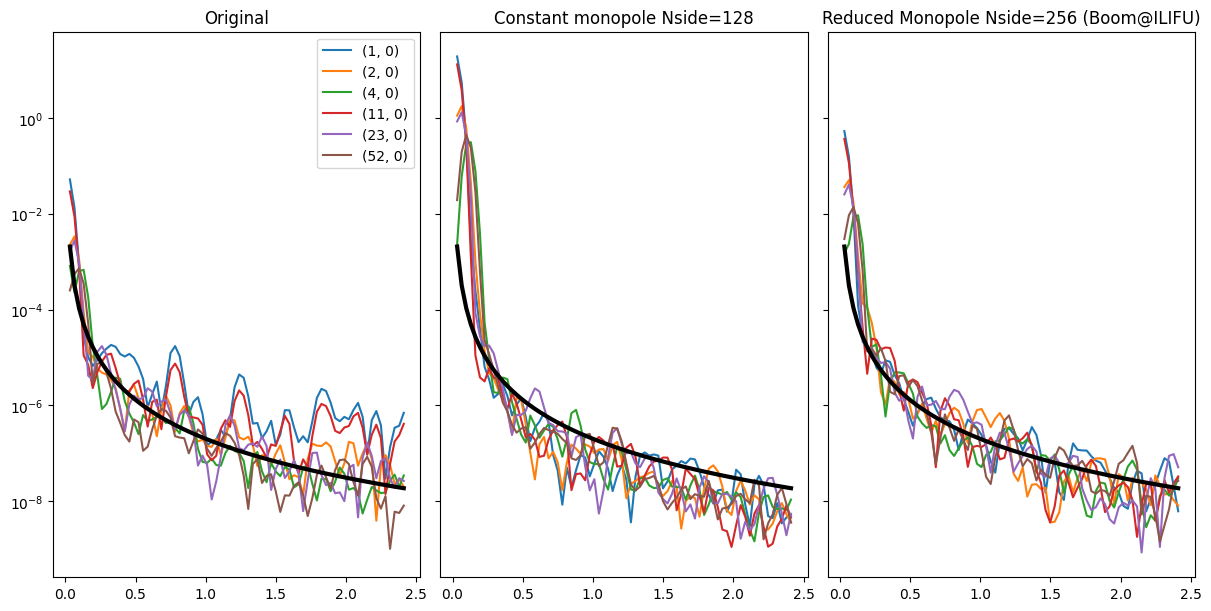

In [42]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 6))

mask = kfft > 0

for bl, porig, pmono, pmono256 in zip(bls, orig_power_pi, bettermono_power_pi, newsim_power_pi):
    ax[0].plot(kfft[mask], porig[mask], label=str(bl))#, color='k', alpha=0.2)
    ax[1].plot(kfft[mask], pmono[mask], label=str(bl))#, color='k', alpha=0.2)
    ax[2].plot(kfft[mask], pmono256[mask], label=str(bl))#, color='k', alpha=0.2)

    #plt.plot(kfft[mask], old_power[mask], ls='--')

expected_pk = 2e-7 * kfft**-2.7
ax[0].plot(kfft[mask], expected_pk[mask], color='k', lw=3)
ax[1].plot(kfft[mask], expected_pk[mask], color='k', lw=3)
ax[2].plot(kfft[mask], expected_pk[mask], color='k', lw=3)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_title("Original")
ax[1].set_title("Constant monopole Nside=128")
ax[2].set_title("Reduced Monopole Nside=256 (Boom@ILIFU)")

ax[0].legend()

In [32]:
24 * 1536

36864

In [34]:
(23.5 * 24 * 1536) / 60

14438.4

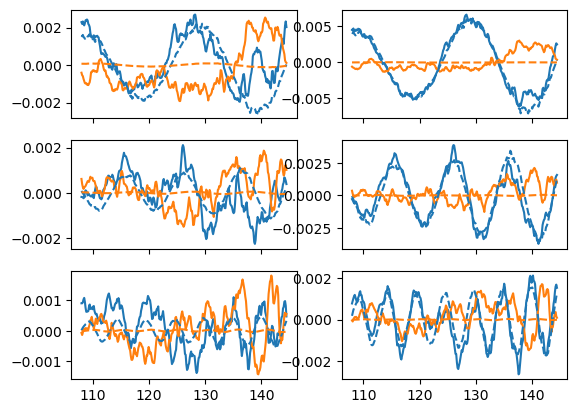

In [162]:
fig, ax = plt.subplots(3,2, sharex=True)

for ant2 in (1,2,3):
    for pol in range(2):
        for sky in range(2):
            ax[ant2-1, pol].plot(h4c_freqs[500:800]/1e6, vis[sky, :, 0, pol, ant2, pol, 0].real, ls='--' if sky else '-', label=f'real, sky={sky}', color='C0')
            ax[ant2-1, pol].plot(h4c_freqs[500:800]/1e6, vis[sky, :, 0, pol, ant2, pol, 0].imag, ls='--' if sky else '-', label=f'imag, sky={sky}', color='C1')

#plt.plot(freqs/1e6, data[:, 0, 0, 0]*1000)

NameError: name 'freqs' is not defined

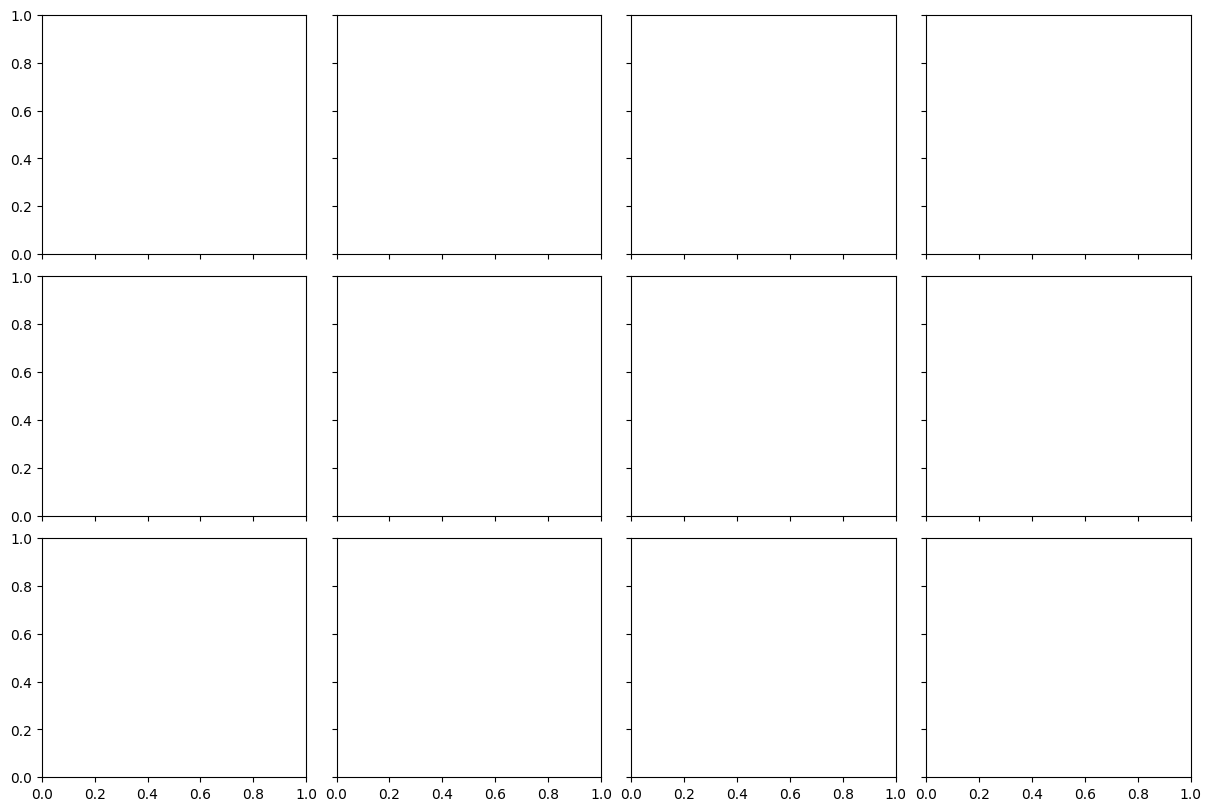

In [21]:
make_plot(bettermonodata, pol='xx');
# make_plot(data, pol='yy');
# make_plot(data, pol='pI');


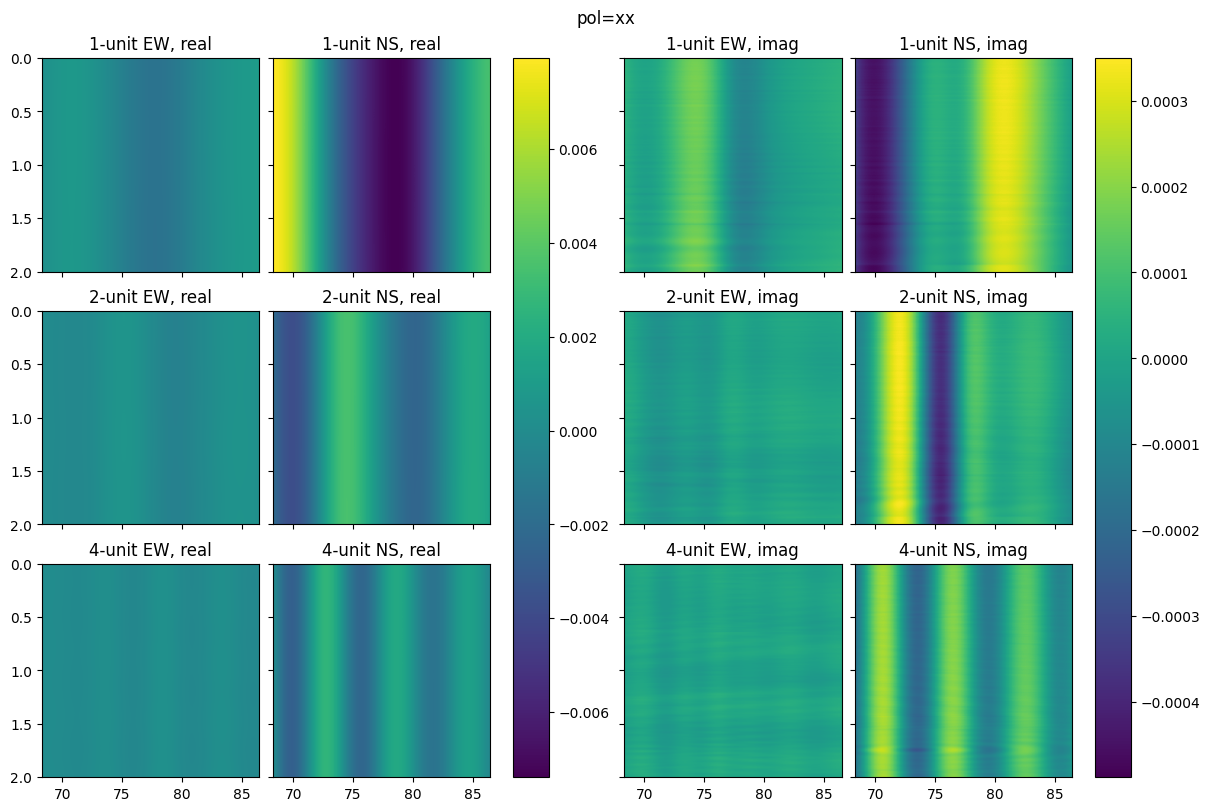

In [93]:
make_plot(monodata, pol='xx');

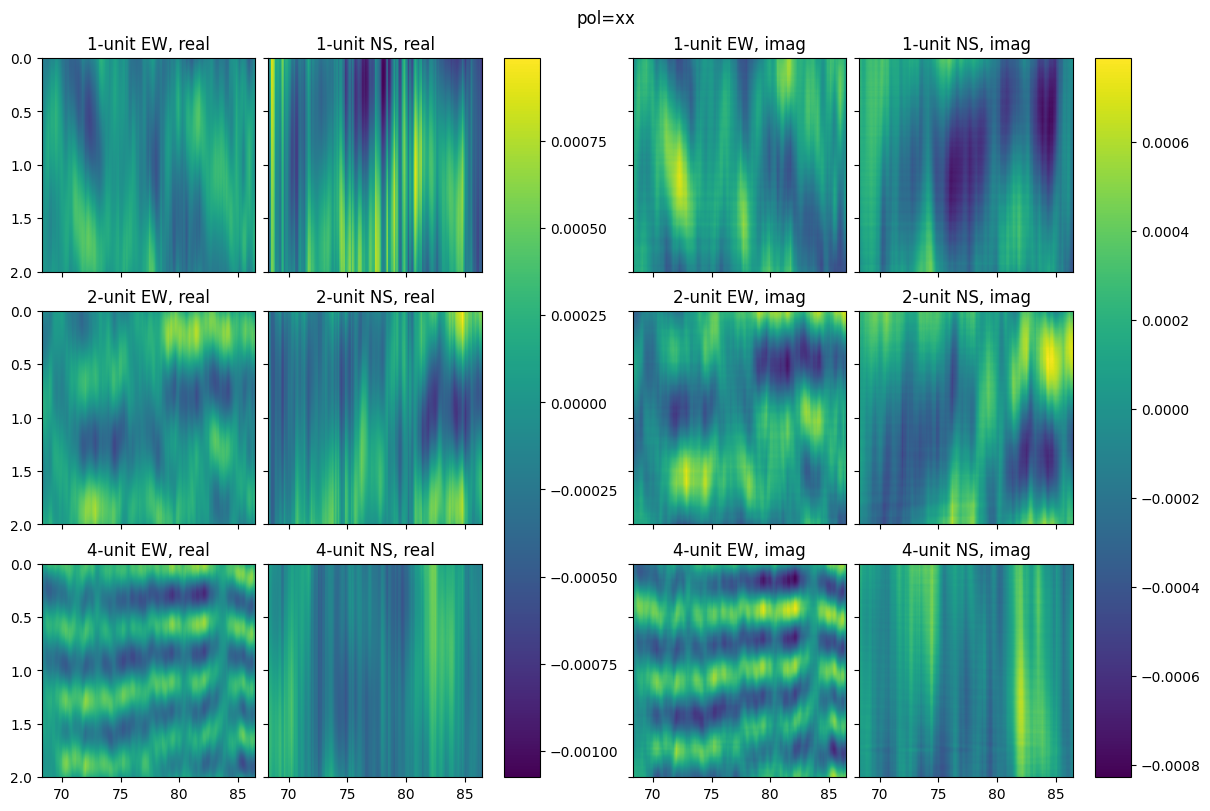

In [94]:
make_plot(fulldata - monodata, pol='xx');

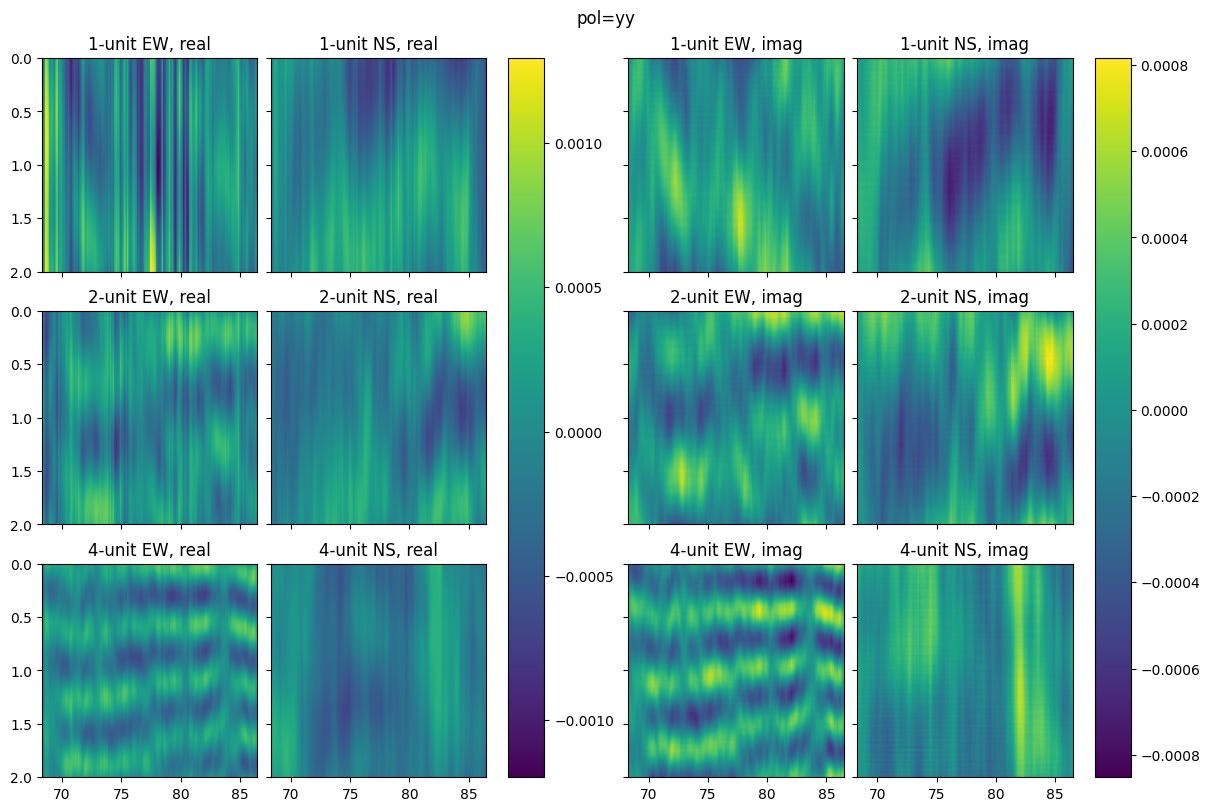

In [138]:
make_plot(fulldata - monodata, pol='yy');

In [26]:
fullpower_xx, kfft = get_power(fulldata, 'xx')
monopower_xx, kfft = get_power(monodata, 'xx')
nomonopower_xx, kfft = get_power(fulldata - monodata, 'xx')

/tmp/ipykernel_141009/122514889.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


In [27]:
fullpower_yy, kfft = get_power(fulldata, 'yy')
monopower_yy, kfft = get_power(monodata, 'yy')
nomonopower_yy, kfft = get_power(fulldata - monodata, 'yy')

/tmp/ipykernel_141009/122514889.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


In [45]:
full256power_xx, kfft = get_power(full256data, 'xx')
full256power_yy, kfft = get_power(full256data, 'yy')


/tmp/ipykernel_141009/122514889.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


In [70]:
def make_power_plot(data):
    pxx, kfft = get_power(data, 'xx')
    pyy, kfft = get_power(data, 'yy')
    
    #mask = np.array([96, 97,  98,  99, 100, 101, 102])

    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 6))

    for i, f in enumerate(pxx):
        bl = meta.antpairs[blidx[i]]
        ax[0].plot(kfft, f, label=bl)
        
    for i, f in enumerate(pyy):
        bl = meta.antpairs[blidx[i]]
        ax[1].plot(kfft, f, label=bl)

    ax[0].set_title("xx pol")
    ax[1].set_title("yy pol")
    ax[0].set_xlim(0, None)
    ax[1].set_xlim(0, None)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].legend()
    fig.supxlabel("k parallel")
    ax[0].set_ylabel("Power")

/tmp/ipykernel_141009/3651154027.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


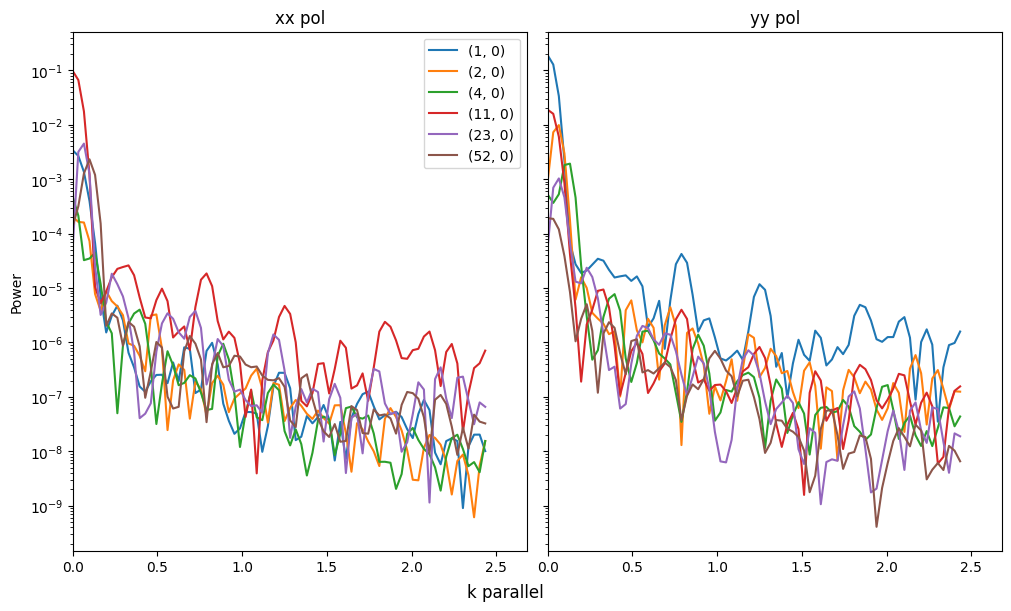

In [106]:
make_power_plot(full256data)

In [49]:
fullrotdata.shape

(150, 360, 6, 4)

In [150]:
little_divet = np.zeros(150)
little_divet[65:85] = 3e-3

In [117]:
power0 = np.abs(np.fft.fftshift(np.fft.fft(blackmanharris(150)*fullrotdata[:, 10, 0, -1])))**2

In [118]:
power1 = np.abs(np.fft.fftshift(np.fft.fft(blackmanharris(150)*fullrotdata[:, 10, 1, -1])))**2

In [151]:
power1_divet = np.abs(np.fft.fftshift(np.fft.fft(blackmanharris(150)*(fullrotdata[:, 10, 1, -1]+ little_divet))))**2

In [113]:
allpower, kfft = get_power(fullrotdata, 'yy')

/tmp/ipykernel_141009/3651154027.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


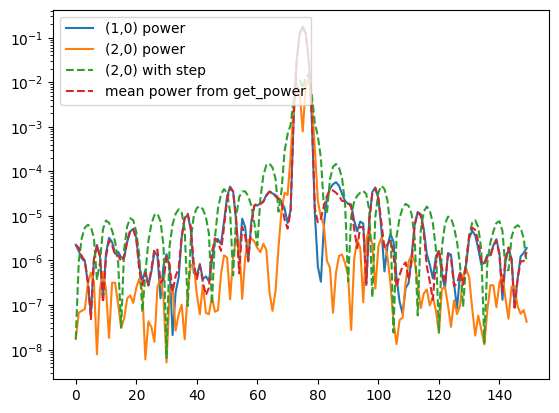

In [152]:
plt.plot(power0, label='(1,0) power')
plt.plot(power1, label='(2,0) power')
plt.plot(power1_divet, label='(2,0) with step', ls='--')
plt.plot(allpower[0], ls='--', label='mean power from get_power')
plt.yscale('log')
plt.legend()

In [166]:
poly = np.polyfit(np.linspace(-1, 1, 150), fullrotdata[:, 10, 0, -1].real, deg=8)
polyim = np.polyfit(np.linspace(-1, 1, 150), fullrotdata[:, 10, 0, -1].imag, deg=8)

In [167]:
poly1 = np.polyfit(np.linspace(-1, 1, 150), fullrotdata[:, 10, 1, -1].real, deg=8)
poly1im = np.polyfit(np.linspace(-1, 1, 150), fullrotdata[:, 10, 1, -1].imag, deg=8)

In [157]:
np.polyval?

Text(0, 0.5, 'Residual to 8-term poly')

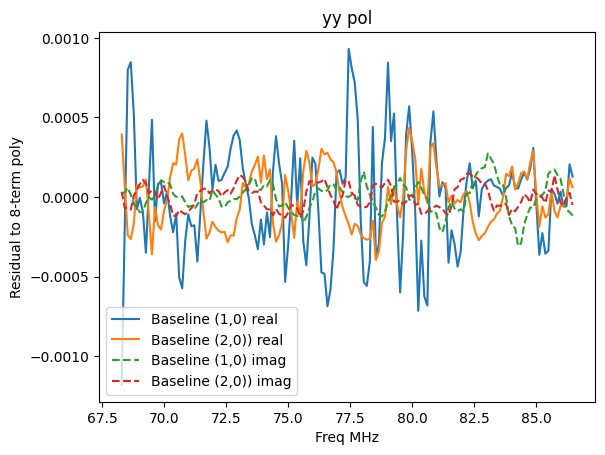

In [169]:
plt.plot(FREQS[175:325]/1e6, fullrotdata[:, 10, 0, -1].real - np.polyval(poly, np.linspace(-1, 1, 150)), label='Baseline (1,0) real')
plt.plot(FREQS[175:325]/1e6, fullrotdata[:, 10, 1, -1].real - np.polyval(poly1, np.linspace(-1, 1, 150)), label='Baseline (2,0)) real')

plt.plot(FREQS[175:325]/1e6, fullrotdata[:, 10, 0, -1].imag - np.polyval(polyim, np.linspace(-1, 1, 150)), label='Baseline (1,0) imag', ls='--')
plt.plot(FREQS[175:325]/1e6, fullrotdata[:, 10, 1, -1].imag - np.polyval(poly1im, np.linspace(-1, 1, 150)), label='Baseline (2,0)) imag', ls='--')
plt.title("yy pol")
plt.legend()
#plt.plot(fullrotdata[:, 10, 0, -1].imag)
plt.xlabel("Freq MHz")
plt.ylabel("Residual to 8-term poly")
# plt.plot(inv.real)
# plt.plot(inv.imag)

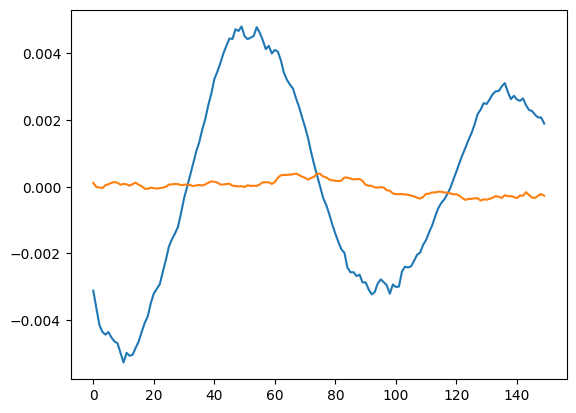

In [108]:
plt.plot(fullrotdata[:, 10, 1, -1].real)
plt.plot(fullrotdata[:, 10, 1, -1].imag)


In [54]:
np.where(np.logical_and(kfft>0.7, kfft<1.0))

(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105]),)

/tmp/ipykernel_141009/122514889.py:7: DeprecationWarning: Importing blackmanharris from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackmanharris' or the convenience function 'scipy.signal.get_window' instead.
  power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2


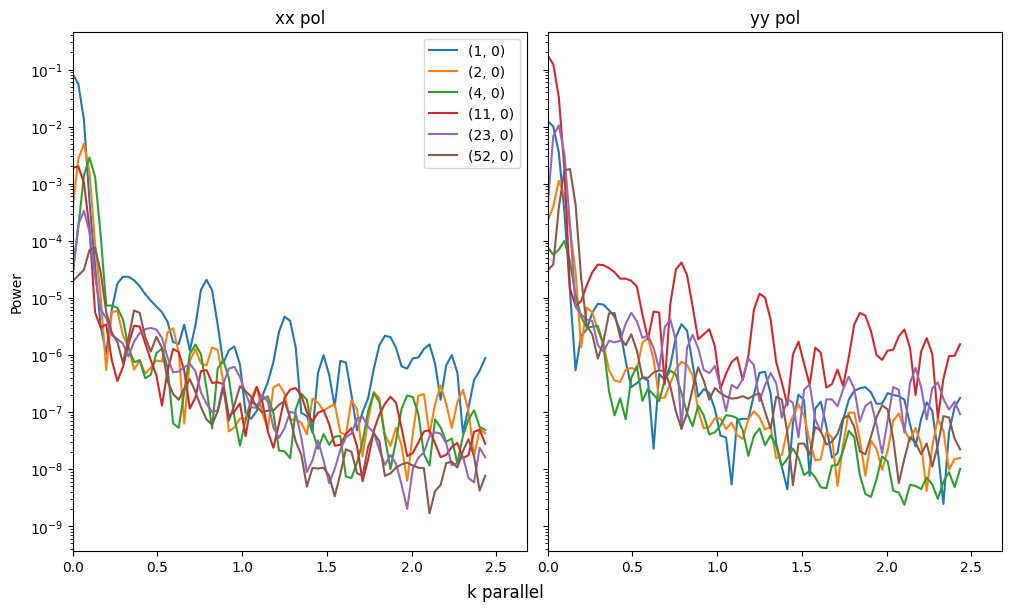

In [72]:
make_power_plot(fullrotdata)

Text(0, 0.5, 'Power')

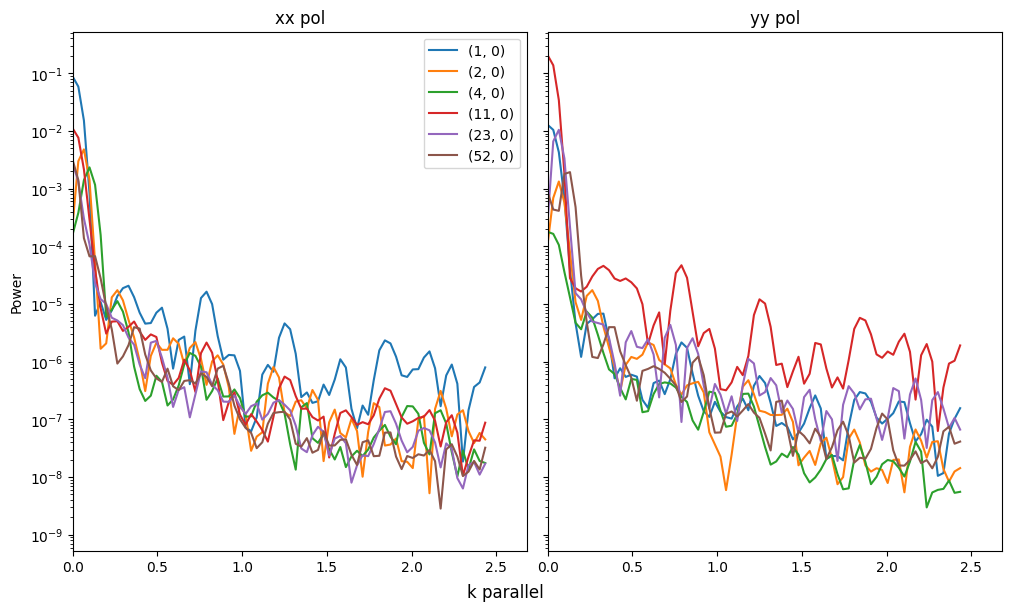

In [71]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 6))

for i, (f, nn) in enumerate(zip(fullpower_xx, nomonopower_xx)):
    bl = meta.antpairs[blidx[i]]
    ax[0].plot(kfft, f, label=bl)

for i, (f, nn) in enumerate(zip(fullpower_yy, nomonopower_yy)):
    bl = meta.antpairs[blidx[i]]
    
    ax[1].plot(kfft, f, label=bl)

ax[0].set_title("xx pol")
ax[1].set_title("yy pol")

#     plt.plot(kfft, monopower, label='monopole')
    #plt.plot(kfft, nn)#, label='eor - monopole')
#plt.xscale('log')
ax[0].set_xlim(0, None)
ax[1].set_xlim(0, None)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].legend()
fig.supxlabel("k parallel")
ax[0].set_ylabel("Power")

In [121]:
nomonodata = fulldata - monodata

In [127]:
meta.pols

['xx', 'xy', 'yx', 'yy']

In [122]:
nomonodata.shape

(150, 720, 6, 4)

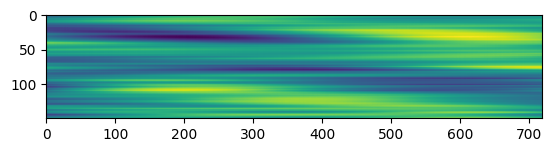

In [130]:
plt.imshow(nomonodata[:, :, 0, 0].real)